>[GPU](#scrollTo=4BbDwnvH-ACc)

>[Import](#scrollTo=wHvV48nv-Pjh)

>[RBF](#scrollTo=UPW16Sk1WlmG)

>[Load MNIST](#scrollTo=RyXoD6z4-lHr)

>[GAN Convolution](#scrollTo=Ql2uJ4u0-03B)

>[GAN Dense](#scrollTo=WNjjTeVvOb3S)

>[Save Images](#scrollTo=s_lCLlWe8mh6)

>[Good examples](#scrollTo=89EK28dD56wz)

>[base rejector](#scrollTo=W8vfGs2JEYcw)

>[rejector](#scrollTo=79fzKlLm2HA4)

>[Classifior](#scrollTo=4tq3NQbiaxDn)



# GPU

In [1]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)


import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


import tensorflow as tf
import timeit

Found GPU at: /device:GPU:0


# Import

In [2]:
#@title Titre par défaut
import numpy as np
np.random.seed(1000)
import tensorflow as tf
import timeit
# https://keras.io/
!pip install -q keras
import keras

!pip install -q tqdm
import tqdm

Using TensorFlow backend.


In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adagrad
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.monitor_interval = 0

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
from keras import initializers
from keras.utils import np_utils

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100


# RBF

In [0]:
from keras.engine import InputSpec, Layer
from keras.legacy import interfaces
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Load MNIST

In [5]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

nb_classes = 10
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9

X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_test = X_test[:, np.newaxis, :, :]
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

11501568/11490434 [==============================] - 1s 0us/step


In [0]:


dossier=[]
resultat=[]

# GAN Convolution

In [7]:
# Optimizer
#adam = Adam(lr=0.0002, beta_1=0.5)

adam = Adagrad(lr=0.001, epsilon=None, decay=0.0)

# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

print (generator.summary())
from keras.layers import BatchNormalization

# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

print (discriminator.summary())

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

gan.summary()

dLosses = []
gLosses = []
cLosses_p =[]
cLosses_r =[]

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    generatedImages1=generatedImages[:, np.newaxis, :, :]
    result=discriminator.predict(generatedImages1)
    for i in range(examples): 
      dossier.append(generatedImages[i,:,:])
      resultat.append(result[i][0])

   # plt.figure(figsize=figsize)
    #for i in range(generatedImages.shape[0]):
     #   plt.subplot(dim[0], dim[1], i+1)
      #  plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
       # plt.axis('off')
   # plt.tight_layout()
    #plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        plotGeneratedImages(e)
       # saveModels(e)

    #    if e == 1 or e % 20 == 0:
    #        plotGeneratedImages(e)
    #        saveModels(e)

    # Plot losses from every epoch
    #plotLoss(e)

if __name__ == '__main__':
    train(200, 128)


  0%|          | 0/468 [00:00<?, ?it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 28, 28)        0         
__________

  0%|          | 2/468 [00:00<00:34, 13.47it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:34, 13.33it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:34, 13.61it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/468 [00:00<00:34, 13.48it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:34, 13.52it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:35, 13.26it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:34, 13.70it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 10 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:34, 13.57it/s]

--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:34, 13.54it/s]

--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:36, 12.88it/s]

--------------- Epoch 15 ---------------


  0%|          | 2/468 [00:00<00:34, 13.44it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:34, 13.62it/s]

--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:34, 13.57it/s]

--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 20 ---------------


  0%|          | 2/468 [00:00<00:36, 12.66it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:35, 13.21it/s]

--------------- Epoch 22 ---------------


  0%|          | 2/468 [00:00<00:36, 12.84it/s]

--------------- Epoch 23 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 24 ---------------


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 25 ---------------


  0%|          | 2/468 [00:00<00:34, 13.44it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 27 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 28 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 29 ---------------


  0%|          | 2/468 [00:00<00:35, 13.29it/s]

--------------- Epoch 30 ---------------


  0%|          | 2/468 [00:00<00:35, 13.20it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 32 ---------------


  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 33 ---------------


  0%|          | 2/468 [00:00<00:34, 13.55it/s]

--------------- Epoch 34 ---------------


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

--------------- Epoch 35 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:34, 13.44it/s]

--------------- Epoch 37 ---------------


  0%|          | 2/468 [00:00<00:36, 12.79it/s]

--------------- Epoch 38 ---------------


  0%|          | 2/468 [00:00<00:35, 13.28it/s]

--------------- Epoch 39 ---------------


  0%|          | 2/468 [00:00<00:35, 12.99it/s]

--------------- Epoch 40 ---------------


  0%|          | 2/468 [00:00<00:35, 13.24it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:34, 13.63it/s]

--------------- Epoch 42 ---------------


  0%|          | 2/468 [00:00<00:34, 13.36it/s]

--------------- Epoch 43 ---------------


  0%|          | 2/468 [00:00<00:33, 13.71it/s]

--------------- Epoch 44 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 45 ---------------


  0%|          | 2/468 [00:00<00:36, 12.92it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:36, 12.78it/s]

--------------- Epoch 47 ---------------


  0%|          | 2/468 [00:00<00:34, 13.53it/s]

--------------- Epoch 48 ---------------


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

--------------- Epoch 49 ---------------


  0%|          | 2/468 [00:00<00:34, 13.39it/s]

--------------- Epoch 50 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 51 ---------------


  0%|          | 2/468 [00:00<00:35, 12.95it/s]

--------------- Epoch 52 ---------------


  0%|          | 2/468 [00:00<00:34, 13.48it/s]

--------------- Epoch 53 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 54 ---------------


  0%|          | 2/468 [00:00<00:35, 13.08it/s]

--------------- Epoch 55 ---------------


  0%|          | 2/468 [00:00<00:35, 13.28it/s]

--------------- Epoch 56 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 57 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 58 ---------------


  0%|          | 2/468 [00:00<00:35, 13.16it/s]

--------------- Epoch 59 ---------------


  0%|          | 2/468 [00:00<00:36, 12.84it/s]

--------------- Epoch 60 ---------------


  0%|          | 2/468 [00:00<00:36, 12.76it/s]

--------------- Epoch 61 ---------------


  0%|          | 2/468 [00:00<00:35, 13.06it/s]

--------------- Epoch 62 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 63 ---------------


  0%|          | 2/468 [00:00<00:35, 13.31it/s]

--------------- Epoch 64 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 65 ---------------


  0%|          | 2/468 [00:00<00:36, 12.66it/s]

--------------- Epoch 66 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 67 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 68 ---------------


  0%|          | 2/468 [00:00<00:34, 13.58it/s]

--------------- Epoch 69 ---------------


  0%|          | 2/468 [00:00<00:35, 13.12it/s]

--------------- Epoch 70 ---------------


  0%|          | 2/468 [00:00<00:35, 12.95it/s]

--------------- Epoch 71 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 72 ---------------


  0%|          | 2/468 [00:00<00:35, 13.19it/s]

--------------- Epoch 73 ---------------


  0%|          | 2/468 [00:00<00:34, 13.50it/s]

--------------- Epoch 74 ---------------


  0%|          | 2/468 [00:00<00:35, 13.09it/s]

--------------- Epoch 75 ---------------


  0%|          | 2/468 [00:00<00:35, 13.14it/s]

--------------- Epoch 76 ---------------


  0%|          | 2/468 [00:00<00:34, 13.51it/s]

--------------- Epoch 77 ---------------


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

--------------- Epoch 78 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 79 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 80 ---------------


  0%|          | 2/468 [00:00<00:34, 13.38it/s]

--------------- Epoch 81 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 82 ---------------


  0%|          | 2/468 [00:00<00:34, 13.39it/s]

--------------- Epoch 83 ---------------


  0%|          | 2/468 [00:00<00:34, 13.46it/s]

--------------- Epoch 84 ---------------


  0%|          | 2/468 [00:00<00:36, 12.89it/s]

--------------- Epoch 85 ---------------


  0%|          | 2/468 [00:00<00:35, 13.11it/s]

--------------- Epoch 86 ---------------


  0%|          | 2/468 [00:00<00:34, 13.44it/s]

--------------- Epoch 87 ---------------


  0%|          | 2/468 [00:00<00:35, 13.20it/s]

--------------- Epoch 88 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 89 ---------------


  0%|          | 2/468 [00:00<00:35, 13.30it/s]

--------------- Epoch 90 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 91 ---------------


  0%|          | 2/468 [00:00<00:35, 13.10it/s]

--------------- Epoch 92 ---------------


  0%|          | 2/468 [00:00<00:34, 13.61it/s]

--------------- Epoch 93 ---------------


  0%|          | 2/468 [00:00<00:34, 13.51it/s]

--------------- Epoch 94 ---------------


  0%|          | 2/468 [00:00<00:35, 13.24it/s]

--------------- Epoch 95 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 96 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 97 ---------------


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

--------------- Epoch 98 ---------------


  0%|          | 2/468 [00:00<00:35, 13.18it/s]

--------------- Epoch 99 ---------------


  0%|          | 2/468 [00:00<00:36, 12.85it/s]

--------------- Epoch 100 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 101 ---------------


  0%|          | 2/468 [00:00<00:34, 13.36it/s]

--------------- Epoch 102 ---------------


  0%|          | 2/468 [00:00<00:35, 13.31it/s]

--------------- Epoch 103 ---------------


  0%|          | 2/468 [00:00<00:34, 13.65it/s]

--------------- Epoch 104 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 105 ---------------


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

--------------- Epoch 106 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 107 ---------------


  0%|          | 2/468 [00:00<00:34, 13.34it/s]

--------------- Epoch 108 ---------------


  0%|          | 2/468 [00:00<00:35, 13.21it/s]

--------------- Epoch 109 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 110 ---------------


  0%|          | 2/468 [00:00<00:36, 12.80it/s]

--------------- Epoch 111 ---------------


  0%|          | 2/468 [00:00<00:34, 13.48it/s]

--------------- Epoch 112 ---------------


  0%|          | 2/468 [00:00<00:34, 13.57it/s]

--------------- Epoch 113 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 114 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 115 ---------------


  0%|          | 2/468 [00:00<00:34, 13.41it/s]

--------------- Epoch 116 ---------------


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 117 ---------------


  0%|          | 2/468 [00:00<00:35, 13.28it/s]

--------------- Epoch 118 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 119 ---------------


  0%|          | 2/468 [00:00<00:34, 13.55it/s]

--------------- Epoch 120 ---------------


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

--------------- Epoch 121 ---------------


  0%|          | 2/468 [00:00<00:36, 12.70it/s]

--------------- Epoch 122 ---------------


  0%|          | 2/468 [00:00<00:35, 13.10it/s]

--------------- Epoch 123 ---------------


  0%|          | 2/468 [00:00<00:34, 13.41it/s]

--------------- Epoch 124 ---------------


  0%|          | 2/468 [00:00<00:35, 13.21it/s]

--------------- Epoch 125 ---------------


  0%|          | 2/468 [00:00<00:35, 13.15it/s]

--------------- Epoch 126 ---------------


  0%|          | 2/468 [00:00<00:35, 13.20it/s]

--------------- Epoch 127 ---------------


  0%|          | 2/468 [00:00<00:34, 13.60it/s]

--------------- Epoch 128 ---------------


  0%|          | 2/468 [00:00<00:33, 13.75it/s]

--------------- Epoch 129 ---------------


  0%|          | 2/468 [00:00<00:34, 13.37it/s]

--------------- Epoch 130 ---------------


  0%|          | 2/468 [00:00<00:35, 13.14it/s]

--------------- Epoch 131 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 132 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 133 ---------------


  0%|          | 2/468 [00:00<00:35, 13.07it/s]

--------------- Epoch 134 ---------------


  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 135 ---------------


  0%|          | 2/468 [00:00<00:34, 13.33it/s]

--------------- Epoch 136 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 137 ---------------


  0%|          | 2/468 [00:00<00:34, 13.40it/s]

--------------- Epoch 138 ---------------


  0%|          | 2/468 [00:00<00:35, 13.28it/s]

--------------- Epoch 139 ---------------


  0%|          | 2/468 [00:00<00:35, 13.27it/s]

--------------- Epoch 140 ---------------


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

--------------- Epoch 141 ---------------


  0%|          | 2/468 [00:00<00:36, 12.88it/s]

--------------- Epoch 142 ---------------


  0%|          | 2/468 [00:00<00:36, 12.94it/s]

--------------- Epoch 143 ---------------


  0%|          | 2/468 [00:00<00:34, 13.49it/s]

--------------- Epoch 144 ---------------


  0%|          | 2/468 [00:00<00:36, 12.81it/s]

--------------- Epoch 145 ---------------


  0%|          | 2/468 [00:00<00:35, 13.14it/s]

--------------- Epoch 146 ---------------


  0%|          | 2/468 [00:00<00:36, 12.74it/s]

--------------- Epoch 147 ---------------


  0%|          | 2/468 [00:00<00:34, 13.33it/s]

--------------- Epoch 148 ---------------


  0%|          | 2/468 [00:00<00:35, 13.05it/s]

--------------- Epoch 149 ---------------


  0%|          | 2/468 [00:00<00:35, 13.16it/s]

--------------- Epoch 150 ---------------


  0%|          | 2/468 [00:00<00:35, 13.13it/s]

--------------- Epoch 151 ---------------


  0%|          | 2/468 [00:00<00:36, 12.76it/s]

--------------- Epoch 152 ---------------


  0%|          | 2/468 [00:00<00:35, 13.31it/s]

--------------- Epoch 153 ---------------


  0%|          | 2/468 [00:00<00:36, 12.88it/s]

--------------- Epoch 154 ---------------


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

--------------- Epoch 155 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 156 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 157 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 158 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 159 ---------------


  0%|          | 2/468 [00:00<00:34, 13.45it/s]

--------------- Epoch 160 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 161 ---------------


  0%|          | 2/468 [00:00<00:36, 12.92it/s]

--------------- Epoch 162 ---------------


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

--------------- Epoch 163 ---------------


  0%|          | 2/468 [00:00<00:34, 13.48it/s]

--------------- Epoch 164 ---------------


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

--------------- Epoch 165 ---------------


  0%|          | 2/468 [00:00<00:35, 12.98it/s]

--------------- Epoch 166 ---------------


  0%|          | 2/468 [00:00<00:35, 13.23it/s]

--------------- Epoch 167 ---------------


  0%|          | 2/468 [00:00<00:37, 12.49it/s]

--------------- Epoch 168 ---------------


  0%|          | 2/468 [00:00<00:36, 12.93it/s]

--------------- Epoch 169 ---------------


  0%|          | 2/468 [00:00<00:35, 13.16it/s]

--------------- Epoch 170 ---------------


  0%|          | 2/468 [00:00<00:35, 13.31it/s]

--------------- Epoch 171 ---------------


  0%|          | 2/468 [00:00<00:35, 13.24it/s]

--------------- Epoch 172 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 173 ---------------


  0%|          | 2/468 [00:00<00:36, 12.67it/s]

--------------- Epoch 174 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 175 ---------------


  0%|          | 2/468 [00:00<00:34, 13.35it/s]

--------------- Epoch 176 ---------------


  0%|          | 2/468 [00:00<00:34, 13.38it/s]

--------------- Epoch 177 ---------------


  0%|          | 2/468 [00:00<00:36, 12.87it/s]

--------------- Epoch 178 ---------------


  0%|          | 2/468 [00:00<00:34, 13.33it/s]

--------------- Epoch 179 ---------------


  0%|          | 2/468 [00:00<00:35, 13.09it/s]

--------------- Epoch 180 ---------------


  0%|          | 2/468 [00:00<00:36, 12.94it/s]

--------------- Epoch 181 ---------------


  0%|          | 2/468 [00:00<00:37, 12.40it/s]

--------------- Epoch 182 ---------------


  0%|          | 2/468 [00:00<00:35, 13.01it/s]

--------------- Epoch 183 ---------------


  0%|          | 2/468 [00:00<00:35, 13.22it/s]

--------------- Epoch 184 ---------------


  0%|          | 2/468 [00:00<00:35, 13.17it/s]

--------------- Epoch 185 ---------------


  0%|          | 2/468 [00:00<00:35, 13.21it/s]

--------------- Epoch 186 ---------------


  0%|          | 2/468 [00:00<00:36, 12.86it/s]

--------------- Epoch 187 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 188 ---------------


  0%|          | 2/468 [00:00<00:34, 13.43it/s]

--------------- Epoch 189 ---------------


  0%|          | 2/468 [00:00<00:34, 13.32it/s]

--------------- Epoch 190 ---------------


  0%|          | 2/468 [00:00<00:35, 13.02it/s]

--------------- Epoch 191 ---------------


  0%|          | 2/468 [00:00<00:34, 13.52it/s]

--------------- Epoch 192 ---------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 193 ---------------


  0%|          | 2/468 [00:00<00:35, 13.20it/s]

--------------- Epoch 194 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 195 ---------------


  0%|          | 2/468 [00:00<00:34, 13.53it/s]

--------------- Epoch 196 ---------------


  0%|          | 2/468 [00:00<00:35, 13.19it/s]

--------------- Epoch 197 ---------------


  0%|          | 2/468 [00:00<00:35, 13.20it/s]

--------------- Epoch 198 ---------------


  0%|          | 2/468 [00:00<00:34, 13.42it/s]

--------------- Epoch 199 ---------------


  0%|          | 2/468 [00:00<00:34, 13.39it/s]

--------------- Epoch 200 ---------------


100%|██████████| 468/468 [00:35<00:00, 13.11it/s]


In [8]:
len(resultat)

20000

# GAN Dense

In [9]:
X_train = X_train.reshape(60000, 784)

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    generatedImages1=generatedImages.reshape(examples, 28*28)
    result=discriminator.predict(generatedImages1)
    for i in range(examples): 
      dossier.append(generatedImages[i,:,:])
      resultat.append(result[i][0])

   # plt.figure(figsize=figsize)
    #for i in range(generatedImages.shape[0]):
     #   plt.subplot(dim[0], dim[1], i+1)
      #  plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
       # plt.axis('off')
   # plt.tight_layout()
    #plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('gan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)
        
       # if e == 1 or e % 20 == 0:
        plotGeneratedImages(e)
       # saveModels(e)

    # Plot losses from every epoch
    #plotLoss(e)

if __name__ == '__main__':
    train(200, 128)


  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


  1%|          | 4/468 [00:00<00:14, 31.56it/s]

--------------- Epoch 2 ---------------


  1%|          | 4/468 [00:00<00:13, 34.59it/s]

--------------- Epoch 3 ---------------


  1%|          | 4/468 [00:00<00:12, 36.19it/s]

--------------- Epoch 4 ---------------


  1%|          | 4/468 [00:00<00:13, 34.19it/s]

--------------- Epoch 5 ---------------


  1%|          | 4/468 [00:00<00:14, 32.81it/s]

--------------- Epoch 6 ---------------


  1%|          | 4/468 [00:00<00:13, 33.47it/s]

--------------- Epoch 7 ---------------


  1%|          | 4/468 [00:00<00:13, 35.02it/s]

--------------- Epoch 8 ---------------


  1%|          | 4/468 [00:00<00:13, 35.38it/s]

--------------- Epoch 9 ---------------


  1%|          | 4/468 [00:00<00:13, 34.69it/s]

--------------- Epoch 10 ---------------


  1%|          | 4/468 [00:00<00:13, 33.38it/s]

--------------- Epoch 11 ---------------


  1%|          | 4/468 [00:00<00:13, 34.37it/s]

--------------- Epoch 12 ---------------


  1%|          | 4/468 [00:00<00:14, 32.92it/s]

--------------- Epoch 13 ---------------


  1%|          | 4/468 [00:00<00:13, 33.73it/s]

--------------- Epoch 14 ---------------


  1%|          | 4/468 [00:00<00:13, 33.26it/s]

--------------- Epoch 15 ---------------


  1%|          | 4/468 [00:00<00:13, 33.40it/s]

--------------- Epoch 16 ---------------


  1%|          | 4/468 [00:00<00:13, 34.54it/s]

--------------- Epoch 17 ---------------


  1%|          | 4/468 [00:00<00:13, 33.28it/s]

--------------- Epoch 18 ---------------


  1%|          | 4/468 [00:00<00:13, 34.19it/s]

--------------- Epoch 19 ---------------


  1%|          | 4/468 [00:00<00:13, 33.89it/s]

--------------- Epoch 20 ---------------


  1%|          | 4/468 [00:00<00:13, 33.40it/s]

--------------- Epoch 21 ---------------


  1%|          | 4/468 [00:00<00:14, 33.13it/s]

--------------- Epoch 22 ---------------


  1%|          | 4/468 [00:00<00:14, 32.62it/s]

--------------- Epoch 23 ---------------


  1%|          | 4/468 [00:00<00:13, 33.89it/s]

--------------- Epoch 24 ---------------


  1%|          | 4/468 [00:00<00:13, 34.59it/s]

--------------- Epoch 25 ---------------


  1%|          | 4/468 [00:00<00:13, 33.53it/s]

--------------- Epoch 26 ---------------


  1%|          | 4/468 [00:00<00:14, 32.75it/s]

--------------- Epoch 27 ---------------


  1%|          | 4/468 [00:00<00:13, 34.32it/s]

--------------- Epoch 28 ---------------


  1%|          | 4/468 [00:00<00:13, 33.78it/s]

--------------- Epoch 29 ---------------


  1%|          | 4/468 [00:00<00:14, 32.92it/s]

--------------- Epoch 30 ---------------


  1%|          | 4/468 [00:00<00:13, 33.27it/s]

--------------- Epoch 31 ---------------


  1%|          | 4/468 [00:00<00:12, 35.72it/s]

--------------- Epoch 32 ---------------


  1%|          | 4/468 [00:00<00:14, 32.52it/s]

--------------- Epoch 33 ---------------


  1%|          | 4/468 [00:00<00:13, 33.15it/s]

--------------- Epoch 34 ---------------


  1%|          | 4/468 [00:00<00:13, 34.19it/s]

--------------- Epoch 35 ---------------


  1%|          | 4/468 [00:00<00:13, 33.21it/s]

--------------- Epoch 36 ---------------


  1%|          | 4/468 [00:00<00:13, 33.77it/s]

--------------- Epoch 37 ---------------


  1%|          | 4/468 [00:00<00:13, 34.92it/s]

--------------- Epoch 38 ---------------


  1%|          | 4/468 [00:00<00:13, 35.66it/s]

--------------- Epoch 39 ---------------


  1%|          | 4/468 [00:00<00:13, 34.46it/s]

--------------- Epoch 40 ---------------


  1%|          | 4/468 [00:00<00:13, 33.90it/s]

--------------- Epoch 41 ---------------


  1%|          | 4/468 [00:00<00:13, 33.25it/s]

--------------- Epoch 42 ---------------


  1%|          | 4/468 [00:00<00:13, 34.09it/s]

--------------- Epoch 43 ---------------


  1%|          | 4/468 [00:00<00:13, 34.77it/s]

--------------- Epoch 44 ---------------


  1%|          | 4/468 [00:00<00:13, 34.08it/s]

--------------- Epoch 45 ---------------


  1%|          | 4/468 [00:00<00:14, 31.98it/s]

--------------- Epoch 46 ---------------


  1%|          | 4/468 [00:00<00:13, 33.66it/s]

--------------- Epoch 47 ---------------


  1%|          | 4/468 [00:00<00:13, 33.77it/s]

--------------- Epoch 48 ---------------


  1%|          | 4/468 [00:00<00:13, 33.62it/s]

--------------- Epoch 49 ---------------


  1%|          | 4/468 [00:00<00:14, 32.71it/s]

--------------- Epoch 50 ---------------


  1%|          | 4/468 [00:00<00:14, 31.91it/s]

--------------- Epoch 51 ---------------


  1%|          | 4/468 [00:00<00:13, 33.80it/s]

--------------- Epoch 52 ---------------


  1%|          | 4/468 [00:00<00:13, 35.26it/s]

--------------- Epoch 53 ---------------


  1%|          | 4/468 [00:00<00:13, 33.54it/s]

--------------- Epoch 54 ---------------


  1%|          | 4/468 [00:00<00:13, 33.24it/s]

--------------- Epoch 55 ---------------


  1%|          | 4/468 [00:00<00:13, 34.01it/s]

--------------- Epoch 56 ---------------


  1%|          | 4/468 [00:00<00:13, 35.43it/s]

--------------- Epoch 57 ---------------


  1%|          | 4/468 [00:00<00:13, 33.64it/s]

--------------- Epoch 58 ---------------


  1%|          | 4/468 [00:00<00:14, 32.11it/s]

--------------- Epoch 59 ---------------


  1%|          | 4/468 [00:00<00:13, 34.36it/s]

--------------- Epoch 60 ---------------


  1%|          | 4/468 [00:00<00:13, 34.54it/s]

--------------- Epoch 61 ---------------


  1%|          | 4/468 [00:00<00:14, 32.28it/s]

--------------- Epoch 62 ---------------


  1%|          | 4/468 [00:00<00:13, 34.61it/s]

--------------- Epoch 63 ---------------


  1%|          | 4/468 [00:00<00:13, 34.74it/s]

--------------- Epoch 64 ---------------


  1%|          | 4/468 [00:00<00:13, 34.83it/s]

--------------- Epoch 65 ---------------


  1%|          | 4/468 [00:00<00:13, 34.64it/s]

--------------- Epoch 66 ---------------


  1%|          | 4/468 [00:00<00:13, 33.41it/s]

--------------- Epoch 67 ---------------


  1%|          | 4/468 [00:00<00:13, 33.77it/s]

--------------- Epoch 68 ---------------


  1%|          | 4/468 [00:00<00:13, 35.68it/s]

--------------- Epoch 69 ---------------


  1%|          | 4/468 [00:00<00:13, 33.44it/s]

--------------- Epoch 70 ---------------


  1%|          | 4/468 [00:00<00:14, 32.38it/s]

--------------- Epoch 71 ---------------


  1%|          | 4/468 [00:00<00:13, 34.20it/s]

--------------- Epoch 72 ---------------


  1%|          | 4/468 [00:00<00:14, 33.11it/s]

--------------- Epoch 73 ---------------


  1%|          | 4/468 [00:00<00:14, 33.03it/s]

--------------- Epoch 74 ---------------


  1%|          | 4/468 [00:00<00:13, 33.19it/s]

--------------- Epoch 75 ---------------


  1%|          | 4/468 [00:00<00:13, 34.74it/s]

--------------- Epoch 76 ---------------


  1%|          | 4/468 [00:00<00:14, 32.13it/s]

--------------- Epoch 77 ---------------


  1%|          | 4/468 [00:00<00:13, 34.07it/s]

--------------- Epoch 78 ---------------


  1%|          | 4/468 [00:00<00:13, 34.46it/s]

--------------- Epoch 79 ---------------


  1%|          | 4/468 [00:00<00:13, 34.15it/s]

--------------- Epoch 80 ---------------


  1%|          | 4/468 [00:00<00:13, 34.07it/s]

--------------- Epoch 81 ---------------


  1%|          | 4/468 [00:00<00:12, 35.87it/s]

--------------- Epoch 82 ---------------


  1%|          | 4/468 [00:00<00:13, 34.55it/s]

--------------- Epoch 83 ---------------


  1%|          | 4/468 [00:00<00:13, 33.85it/s]

--------------- Epoch 84 ---------------


  1%|          | 4/468 [00:00<00:13, 34.71it/s]

--------------- Epoch 85 ---------------


  1%|          | 4/468 [00:00<00:13, 34.66it/s]

--------------- Epoch 86 ---------------


  1%|          | 4/468 [00:00<00:13, 35.20it/s]

--------------- Epoch 87 ---------------


  1%|          | 4/468 [00:00<00:12, 35.94it/s]

--------------- Epoch 88 ---------------


  1%|          | 4/468 [00:00<00:13, 33.45it/s]

--------------- Epoch 89 ---------------


  1%|          | 4/468 [00:00<00:13, 33.50it/s]

--------------- Epoch 90 ---------------


  1%|          | 4/468 [00:00<00:14, 32.83it/s]

--------------- Epoch 91 ---------------


  1%|          | 4/468 [00:00<00:13, 34.78it/s]

--------------- Epoch 92 ---------------


  1%|          | 4/468 [00:00<00:13, 33.45it/s]

--------------- Epoch 93 ---------------


  1%|          | 4/468 [00:00<00:13, 33.24it/s]

--------------- Epoch 94 ---------------


  1%|          | 4/468 [00:00<00:13, 34.68it/s]

--------------- Epoch 95 ---------------


  1%|          | 4/468 [00:00<00:13, 33.27it/s]

--------------- Epoch 96 ---------------


  1%|          | 4/468 [00:00<00:13, 34.94it/s]

--------------- Epoch 97 ---------------


  1%|          | 4/468 [00:00<00:13, 33.44it/s]

--------------- Epoch 98 ---------------


  1%|          | 4/468 [00:00<00:12, 35.88it/s]

--------------- Epoch 99 ---------------


  1%|          | 4/468 [00:00<00:13, 33.87it/s]

--------------- Epoch 100 ---------------


  1%|          | 4/468 [00:00<00:13, 33.76it/s]

--------------- Epoch 101 ---------------


  1%|          | 4/468 [00:00<00:14, 31.88it/s]

--------------- Epoch 102 ---------------


  1%|          | 4/468 [00:00<00:13, 34.81it/s]

--------------- Epoch 103 ---------------


  1%|          | 4/468 [00:00<00:13, 33.25it/s]

--------------- Epoch 104 ---------------


  1%|          | 4/468 [00:00<00:13, 34.54it/s]

--------------- Epoch 105 ---------------


  1%|          | 4/468 [00:00<00:12, 36.10it/s]

--------------- Epoch 106 ---------------


  1%|          | 4/468 [00:00<00:13, 34.74it/s]

--------------- Epoch 107 ---------------


  1%|          | 4/468 [00:00<00:13, 34.72it/s]

--------------- Epoch 108 ---------------


  1%|          | 4/468 [00:00<00:13, 34.27it/s]

--------------- Epoch 109 ---------------


  1%|          | 4/468 [00:00<00:13, 33.31it/s]

--------------- Epoch 110 ---------------


  1%|          | 4/468 [00:00<00:13, 34.69it/s]

--------------- Epoch 111 ---------------


  1%|          | 4/468 [00:00<00:13, 33.81it/s]

--------------- Epoch 112 ---------------


  1%|          | 4/468 [00:00<00:13, 33.37it/s]

--------------- Epoch 113 ---------------


  1%|          | 4/468 [00:00<00:13, 34.52it/s]

--------------- Epoch 114 ---------------


  1%|          | 4/468 [00:00<00:13, 35.55it/s]

--------------- Epoch 115 ---------------


  1%|          | 4/468 [00:00<00:13, 34.41it/s]

--------------- Epoch 116 ---------------


  1%|          | 4/468 [00:00<00:13, 35.34it/s]

--------------- Epoch 117 ---------------


  1%|          | 4/468 [00:00<00:12, 35.79it/s]

--------------- Epoch 118 ---------------


  1%|          | 4/468 [00:00<00:13, 34.32it/s]

--------------- Epoch 119 ---------------


  1%|          | 4/468 [00:00<00:13, 34.72it/s]

--------------- Epoch 120 ---------------


  1%|          | 4/468 [00:00<00:13, 34.46it/s]

--------------- Epoch 121 ---------------


  1%|          | 4/468 [00:00<00:13, 33.42it/s]

--------------- Epoch 122 ---------------


  1%|          | 4/468 [00:00<00:13, 34.22it/s]

--------------- Epoch 123 ---------------


  1%|          | 4/468 [00:00<00:14, 32.74it/s]

--------------- Epoch 124 ---------------


  1%|          | 4/468 [00:00<00:14, 33.00it/s]

--------------- Epoch 125 ---------------


  1%|          | 4/468 [00:00<00:13, 35.19it/s]

--------------- Epoch 126 ---------------


  1%|          | 4/468 [00:00<00:14, 32.51it/s]

--------------- Epoch 127 ---------------


  1%|          | 4/468 [00:00<00:13, 34.46it/s]

--------------- Epoch 128 ---------------


  1%|          | 4/468 [00:00<00:13, 34.45it/s]

--------------- Epoch 129 ---------------


  1%|          | 4/468 [00:00<00:14, 32.23it/s]

--------------- Epoch 130 ---------------


  1%|          | 4/468 [00:00<00:13, 35.10it/s]

--------------- Epoch 131 ---------------


  1%|          | 4/468 [00:00<00:14, 32.98it/s]

--------------- Epoch 132 ---------------


  1%|          | 4/468 [00:00<00:13, 34.11it/s]

--------------- Epoch 133 ---------------


  1%|          | 4/468 [00:00<00:13, 35.27it/s]

--------------- Epoch 134 ---------------


  1%|          | 4/468 [00:00<00:14, 32.86it/s]

--------------- Epoch 135 ---------------


  1%|          | 3/468 [00:00<00:15, 29.31it/s]

--------------- Epoch 136 ---------------


  1%|          | 4/468 [00:00<00:13, 33.73it/s]

--------------- Epoch 137 ---------------


  1%|          | 4/468 [00:00<00:13, 35.40it/s]

--------------- Epoch 138 ---------------


  1%|          | 4/468 [00:00<00:12, 35.85it/s]

--------------- Epoch 139 ---------------


  1%|          | 4/468 [00:00<00:13, 33.51it/s]

--------------- Epoch 140 ---------------


  1%|          | 4/468 [00:00<00:13, 34.58it/s]

--------------- Epoch 141 ---------------


  1%|          | 4/468 [00:00<00:13, 33.49it/s]

--------------- Epoch 142 ---------------


  1%|          | 4/468 [00:00<00:13, 34.90it/s]

--------------- Epoch 143 ---------------


  1%|          | 4/468 [00:00<00:13, 33.90it/s]

--------------- Epoch 144 ---------------


  1%|          | 4/468 [00:00<00:13, 33.25it/s]

--------------- Epoch 145 ---------------


  1%|          | 4/468 [00:00<00:13, 33.90it/s]

--------------- Epoch 146 ---------------


  1%|          | 4/468 [00:00<00:13, 33.44it/s]

--------------- Epoch 147 ---------------


  1%|          | 4/468 [00:00<00:13, 33.70it/s]

--------------- Epoch 148 ---------------


  1%|          | 4/468 [00:00<00:14, 33.08it/s]

--------------- Epoch 149 ---------------


  1%|          | 4/468 [00:00<00:14, 32.52it/s]

--------------- Epoch 150 ---------------


  1%|          | 4/468 [00:00<00:13, 35.01it/s]

--------------- Epoch 151 ---------------


  1%|          | 4/468 [00:00<00:13, 34.77it/s]

--------------- Epoch 152 ---------------


  1%|          | 4/468 [00:00<00:13, 34.55it/s]

--------------- Epoch 153 ---------------


  1%|          | 4/468 [00:00<00:13, 35.44it/s]

--------------- Epoch 154 ---------------


  1%|          | 4/468 [00:00<00:13, 33.92it/s]

--------------- Epoch 155 ---------------


  1%|          | 4/468 [00:00<00:13, 33.63it/s]

--------------- Epoch 156 ---------------


  1%|          | 4/468 [00:00<00:13, 34.42it/s]

--------------- Epoch 157 ---------------


  1%|          | 4/468 [00:00<00:13, 33.48it/s]

--------------- Epoch 158 ---------------


  1%|          | 4/468 [00:00<00:13, 34.68it/s]

--------------- Epoch 159 ---------------


  1%|          | 4/468 [00:00<00:13, 35.22it/s]

--------------- Epoch 160 ---------------


  1%|          | 4/468 [00:00<00:13, 34.22it/s]

--------------- Epoch 161 ---------------


  1%|          | 4/468 [00:00<00:13, 34.97it/s]

--------------- Epoch 162 ---------------


  1%|          | 4/468 [00:00<00:13, 34.86it/s]

--------------- Epoch 163 ---------------


  1%|          | 4/468 [00:00<00:13, 34.78it/s]

--------------- Epoch 164 ---------------


  1%|          | 4/468 [00:00<00:13, 35.40it/s]

--------------- Epoch 165 ---------------


  1%|          | 4/468 [00:00<00:13, 33.32it/s]

--------------- Epoch 166 ---------------


  1%|          | 4/468 [00:00<00:13, 34.85it/s]

--------------- Epoch 167 ---------------


  1%|          | 4/468 [00:00<00:13, 34.99it/s]

--------------- Epoch 168 ---------------


  1%|          | 4/468 [00:00<00:13, 34.83it/s]

--------------- Epoch 169 ---------------


  1%|          | 4/468 [00:00<00:13, 34.50it/s]

--------------- Epoch 170 ---------------


  1%|          | 4/468 [00:00<00:13, 33.29it/s]

--------------- Epoch 171 ---------------


  1%|          | 4/468 [00:00<00:14, 33.07it/s]

--------------- Epoch 172 ---------------


  1%|          | 4/468 [00:00<00:14, 32.49it/s]

--------------- Epoch 173 ---------------


  1%|          | 4/468 [00:00<00:13, 33.18it/s]

--------------- Epoch 174 ---------------


  1%|          | 4/468 [00:00<00:13, 34.75it/s]

--------------- Epoch 175 ---------------


  1%|          | 4/468 [00:00<00:13, 35.21it/s]

--------------- Epoch 176 ---------------


  1%|          | 4/468 [00:00<00:13, 34.63it/s]

--------------- Epoch 177 ---------------


  1%|          | 4/468 [00:00<00:13, 34.45it/s]

--------------- Epoch 178 ---------------


  1%|          | 4/468 [00:00<00:13, 33.29it/s]

--------------- Epoch 179 ---------------


  1%|          | 4/468 [00:00<00:13, 34.89it/s]

--------------- Epoch 180 ---------------


  1%|          | 4/468 [00:00<00:13, 34.34it/s]

--------------- Epoch 181 ---------------


  1%|          | 4/468 [00:00<00:13, 35.08it/s]

--------------- Epoch 182 ---------------


  1%|          | 4/468 [00:00<00:13, 33.43it/s]

--------------- Epoch 183 ---------------


  1%|          | 4/468 [00:00<00:12, 36.53it/s]

--------------- Epoch 184 ---------------


  1%|          | 4/468 [00:00<00:13, 34.64it/s]

--------------- Epoch 185 ---------------


  1%|          | 4/468 [00:00<00:13, 33.86it/s]

--------------- Epoch 186 ---------------


  1%|          | 4/468 [00:00<00:13, 33.41it/s]

--------------- Epoch 187 ---------------


  1%|          | 4/468 [00:00<00:13, 33.31it/s]

--------------- Epoch 188 ---------------


  1%|          | 4/468 [00:00<00:13, 34.87it/s]

--------------- Epoch 189 ---------------


  1%|          | 4/468 [00:00<00:14, 33.08it/s]

--------------- Epoch 190 ---------------


  1%|          | 4/468 [00:00<00:13, 34.53it/s]

--------------- Epoch 191 ---------------


  1%|          | 4/468 [00:00<00:13, 34.22it/s]

--------------- Epoch 192 ---------------


  1%|          | 4/468 [00:00<00:13, 33.81it/s]

--------------- Epoch 193 ---------------


  1%|          | 4/468 [00:00<00:14, 33.13it/s]

--------------- Epoch 194 ---------------


  1%|          | 4/468 [00:00<00:13, 35.27it/s]

--------------- Epoch 195 ---------------


  1%|          | 4/468 [00:00<00:13, 34.82it/s]

--------------- Epoch 196 ---------------


  1%|          | 4/468 [00:00<00:13, 33.43it/s]

--------------- Epoch 197 ---------------


  1%|          | 4/468 [00:00<00:13, 33.88it/s]

--------------- Epoch 198 ---------------


  1%|          | 4/468 [00:00<00:13, 35.37it/s]

--------------- Epoch 199 ---------------


  1%|          | 4/468 [00:00<00:13, 34.09it/s]

--------------- Epoch 200 ---------------


100%|██████████| 468/468 [00:13<00:00, 34.09it/s]


# Save Images in a DataFrame

In [0]:
dossier1=[]
for i in range(len(dossier)):
  dossier1.append(dossier[i].reshape(28*28))
  
dossier1=np.reshape(dossier1,(len(dossier),28*28))

In [0]:
dossier1.shape
import pandas as pd
dossier1=pd.DataFrame(dossier1)
dossier1['resultat']=pd.Series(resultat)

# Good examples

In [0]:
seuil=0.48
good_examples=dossier1[(dossier1.resultat>seuil)]

good_examples=good_examples.drop(['resultat'],axis=1)

In [53]:
good_examples=good_examples.reset_index()
good_examples=good_examples.drop(['level_0'],axis=1)
good_examples=good_examples.drop(['index'],axis=1)

good_examples.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-0.983227,-0.993217,-0.995469,-0.996149,-0.996065,-0.996918,-0.998670,-0.998696,-0.999168,-0.999693,...,-0.999806,-0.999166,-0.998058,-0.996066,-0.997863,-0.999571,-0.999890,-0.999945,-0.999610,-0.997905
1,-0.990363,-0.997725,-0.998300,-0.998861,-0.999054,-0.999130,-0.999862,-0.999935,-0.999973,-0.999963,...,-0.999070,-0.999068,-0.999056,-0.999489,-0.999407,-0.999237,-0.998847,-0.999223,-0.997654,-0.991551
2,-0.994364,-0.999487,-0.999920,-0.999904,-0.999884,-0.999623,-0.998228,-0.996502,-0.989637,-0.992420,...,-0.970849,-0.990397,-0.998301,-0.999411,-0.999759,-0.999904,-0.999948,-0.999978,-0.999905,-0.999504
3,-0.997474,-0.999623,-0.999951,-0.999866,-0.999580,-0.999939,-0.999988,-0.999998,-1.000000,-0.999998,...,-0.999962,-0.999423,-0.998685,-0.999785,-0.999987,-0.999998,-0.999999,-0.999999,-0.999972,-0.999607
4,-0.987982,-0.999009,-0.999977,-0.999984,-0.999962,-0.999963,-0.999955,-0.999967,-0.999984,-0.999974,...,-0.999991,-0.999957,-0.999860,-0.999941,-0.999952,-0.999980,-0.999982,-0.999969,-0.999721,-0.998422


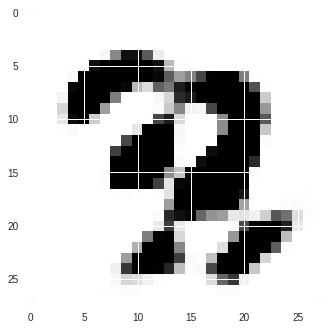

In [56]:

plt.imshow(good_examples.ix[1].values.reshape(28,28), interpolation='nearest', cmap='gray_r')



In [0]:
good_examples['target']=0.9

In [57]:
good_examples.describe()


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
count,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,...,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000
mean,-0.995176,-0.993766,-0.996131,-0.996940,-0.995033,-0.994356,-0.994659,-0.993177,-0.995948,-0.996043,...,-0.995247,-0.994506,-0.995754,-0.995953,-0.996218,-0.995564,-0.996984,-0.994430,-0.994446,-0.994867
std,0.022676,0.071719,0.030761,0.021868,0.058353,0.068595,0.056665,0.090976,0.028683,0.022478,...,0.044414,0.043754,0.044672,0.048292,0.040180,0.056766,0.036540,0.064524,0.062713,0.043451
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.999997,-0.999998,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999999
50%,-0.999690,-0.999968,-0.999994,-0.999994,-0.999998,-0.999997,-0.999997,-0.999997,-0.999995,-0.999996,...,-0.999999,-0.999996,-0.999998,-0.999999,-0.999999,-0.999999,-0.999999,-0.999999,-0.999998,-0.999978
75%,-0.997382,-0.999635,-0.999862,-0.999796,-0.999907,-0.999875,-0.999838,-0.999876,-0.999832,-0.999779,...,-0.999886,-0.999799,-0.999833,-0.999874,-0.999893,-0.999910,-0.999924,-0.999925,-0.999897,-0.999665
max,-0.554537,0.973915,-0.473082,-0.504714,0.898213,0.927467,0.562766,0.997642,-0.449555,-0.625932,...,0.300256,0.106140,0.301157,0.593253,0.266494,0.692286,0.354387,0.742561,0.787538,0.058935


# Creer base rejector

In [0]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = (X_train.astype(np.float32) - 127.5)/127.5

X_train=pd.DataFrame(X_train.reshape(60000,28*28))
#good examples same reshape as X train 
X_train['target']=0

X_train=X_train.append(good_examples)


In [0]:
from sklearn.utils import shuffle
X_train = shuffle(X_train)


In [0]:
X_train.to_csv('X_train_48.csv',index=False)

In [36]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'X_train.csv'})
uploaded.SetContentFile('X_train.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1wwp5a8iHb8WXXQ336y6sGHluVhaf6qhm


# rejector with 1 output

In [0]:


# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1wwp5a8iHb8WXXQ336y6sGHluVhaf6qhm'}) # replace the id with id of file you want to access
downloaded.GetContentFile('X_train.csv')  

#3. Read file as panda dataframe
import pandas as pd
xyz = pd.read_csv('X_train.csv') 

In [8]:
xyz.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.0
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,0.0
2,-0.999997,-0.999977,-0.999994,-0.999999,-0.999640,-1.000000,-0.999999,-0.999997,-1.00000,-0.999945,...,-0.99996,-0.999963,-0.999997,-1.000000,-0.999732,-1.0,-0.999999,-1.000000,-1.000000,0.9
3,-0.952197,-0.990655,-0.999071,-0.999034,-0.999355,-0.998921,-0.999309,-0.999701,-0.99991,-0.999990,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-0.999998,0.9
4,-1.000000,-1.000000,-0.999999,-1.000000,-1.000000,-1.000000,-0.999998,-1.000000,-1.00000,-1.000000,...,-1.00000,-0.999999,-1.000000,-0.999999,-0.999999,-1.0,-0.999998,-0.999989,-1.000000,0.9


In [33]:
########################################"True"
from keras import activations, initializers, regularizers, constraints,metrics
from keras.optimizers import Adam, Adagrad
adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles


# Rejector
rejector= Sequential()
rejector.add(Conv2D(64, kernel_size=(3, 3), padding='same', input_shape=(1, 28, 28),activation='relu'))
rejector.add(MaxPooling2D(pool_size=(3, 3)))
rejector.add(Conv2D(128, (3, 3), activation='relu') )
rejector.add(MaxPooling2D(pool_size=(3, 3)) )
rejector.add(Dropout(0.25))
rejector.add(Flatten())
rejector.add(Dense(128, activation='relu'))
rejector.add(RBF2(300) )
rejector.add(RBFLayer(alpha=2000.0) )
rejector.add(Dense(1, activation='sigmoid', name='r_output', use_bias=False))


rejector.compile(optimizer=adagrad, loss= 'mse', metrics=['acc'])  #  metrics=['acc', f1, precision, recall])
rejector.summary()

('Shapes : ', TensorShape([Dimension(None), Dimension(1)]), TensorShape([Dimension(300)]), TensorShape([Dimension(None), Dimension(300)]))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 28, 28)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 9, 9)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 7, 7)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 2, 2)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 2, 2)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
___

In [0]:
from sklearn.model_selection import train_test_split
xyz.target[xyz.target!=0]=0.9
xyz_train,xyz_val=train_test_split(xyz,test_size=0.2)
y_train=xyz_train.target.values
x_train=xyz_train.drop(['target'],axis=1)
y_val=xyz_val.target.values
x_val=xyz_val.drop(['target'],axis=1)

In [35]:
x_train.shape
#x_val.shape

(73266, 784)

In [0]:
x_train=x_train.values.astype('float32').reshape(73266,1,28,28)
x_val=x_val.values.astype('float32').reshape(18317,1,28,28)

In [37]:
x_train[0].shape

(1, 28, 28)

In [38]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 60
rejector.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (x_val, y_val))

Train on 73266 samples, validate on 18317 samples
Epoch 1/50
73266/73266 [==============================] - 18s 251us/step - loss: 0.1809 - acc: 0.6561 - val_loss: 0.1796 - val_acc: 0.6514
Epoch 2/50
46860/73266 [==================>...........] - ETA: 6s - loss: 0.1750 - acc: 0.6568

73266/73266 [==============================] - 18s 247us/step - loss: 0.1737 - acc: 0.6561 - val_loss: 0.1714 - val_acc: 0.6514
Epoch 3/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1668 - acc: 0.6561 - val_loss: 0.1647 - val_acc: 0.6514
Epoch 4/50
14400/73266 [====>.........................] - ETA: 13s - loss: 0.1619 - acc: 0.6578

73266/73266 [==============================] - 18s 246us/step - loss: 0.1604 - acc: 0.6561 - val_loss: 0.1584 - val_acc: 0.6514

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 5/50
63300/73266 [========================>.....] - ETA: 2s - loss: 0.1566 - acc: 0.6553

73266/73266 [==============================] - 18s 246us/step - loss: 0.1563 - acc: 0.6561 - val_loss: 0.1558 - val_acc: 0.6514
Epoch 6/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1539 - acc: 0.6561 - val_loss: 0.1541 - val_acc: 0.6514
Epoch 7/50
18300/73266 [======>.......................] - ETA: 12s - loss: 0.1539 - acc: 0.6535

73266/73266 [==============================] - 18s 248us/step - loss: 0.1521 - acc: 0.6561 - val_loss: 0.1522 - val_acc: 0.6514

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 8/50
64140/73266 [=========================>....] - ETA: 2s - loss: 0.1505 - acc: 0.6563

73266/73266 [==============================] - 18s 247us/step - loss: 0.1507 - acc: 0.6561 - val_loss: 0.1510 - val_acc: 0.6514
Epoch 9/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1499 - acc: 0.6561 - val_loss: 0.1503 - val_acc: 0.6514
Epoch 10/50
18240/73266 [======>.......................] - ETA: 12s - loss: 0.1491 - acc: 0.6579

73266/73266 [==============================] - 18s 247us/step - loss: 0.1492 - acc: 0.6561 - val_loss: 0.1495 - val_acc: 0.6514

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 11/50
64020/73266 [=========================>....] - ETA: 2s - loss: 0.1493 - acc: 0.6552

73266/73266 [==============================] - 18s 248us/step - loss: 0.1487 - acc: 0.6561 - val_loss: 0.1493 - val_acc: 0.6514
Epoch 12/50
73266/73266 [==============================] - 18s 249us/step - loss: 0.1483 - acc: 0.6561 - val_loss: 0.1490 - val_acc: 0.6514
Epoch 13/50
18000/73266 [======>.......................] - ETA: 12s - loss: 0.1481 - acc: 0.6541

73266/73266 [==============================] - 18s 249us/step - loss: 0.1482 - acc: 0.6561 - val_loss: 0.1486 - val_acc: 0.6514

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 14/50
63840/73266 [=========================>....] - ETA: 2s - loss: 0.1475 - acc: 0.6570

73266/73266 [==============================] - 18s 249us/step - loss: 0.1478 - acc: 0.6561 - val_loss: 0.1485 - val_acc: 0.6514
Epoch 15/50
73266/73266 [==============================] - 18s 248us/step - loss: 0.1477 - acc: 0.6561 - val_loss: 0.1483 - val_acc: 0.6514
Epoch 16/50
18060/73266 [======>.......................] - ETA: 12s - loss: 0.1459 - acc: 0.6613

73266/73266 [==============================] - 18s 249us/step - loss: 0.1476 - acc: 0.6561 - val_loss: 0.1482 - val_acc: 0.6514

Epoch 00016: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 17/50
63900/73266 [=========================>....] - ETA: 2s - loss: 0.1475 - acc: 0.6561

73266/73266 [==============================] - 18s 247us/step - loss: 0.1475 - acc: 0.6561 - val_loss: 0.1482 - val_acc: 0.6514
Epoch 18/50
73266/73266 [==============================] - 18s 250us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1481 - val_acc: 0.6514
Epoch 19/50
17880/73266 [======>.......................] - ETA: 12s - loss: 0.1474 - acc: 0.6559

73266/73266 [==============================] - 18s 251us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1481 - val_acc: 0.6514

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 20/50
64020/73266 [=========================>....] - ETA: 2s - loss: 0.1470 - acc: 0.6572

73266/73266 [==============================] - 18s 250us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1480 - val_acc: 0.6514
Epoch 21/50
73266/73266 [==============================] - 18s 249us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1480 - val_acc: 0.6514
Epoch 22/50
18000/73266 [======>.......................] - ETA: 12s - loss: 0.1475 - acc: 0.6563

73266/73266 [==============================] - 18s 248us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1480 - val_acc: 0.6514

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 23/50
66540/73266 [==========================>...] - ETA: 1s - loss: 0.1470 - acc: 0.6567

73266/73266 [==============================] - 18s 250us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1480 - val_acc: 0.6514
Epoch 24/50
73266/73266 [==============================] - 18s 250us/step - loss: 0.1474 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 25/50
18480/73266 [======>.......................] - ETA: 12s - loss: 0.1465 - acc: 0.6584

73266/73266 [==============================] - 18s 248us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 26/50
73266/73266 [==============================] - 18s 249us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 27/50
 7740/73266 [==>...........................] - ETA: 15s - loss: 0.1469 - acc: 0.6553

73266/73266 [==============================] - 18s 247us/step - loss: 0.1472 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 28/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1472 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 29/50
 5340/73266 [=>............................] - ETA: 15s - loss: 0.1485 - acc: 0.6532

73266/73266 [==============================] - 18s 249us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1479 - val_acc: 0.6514
Epoch 30/50
73266/73266 [==============================] - 18s 249us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 31/50
 4620/73266 [>.............................] - ETA: 15s - loss: 0.1489 - acc: 0.6498

73266/73266 [==============================] - 18s 247us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 32/50
73266/73266 [==============================] - 18s 248us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 33/50
 4380/73266 [>.............................] - ETA: 15s - loss: 0.1460 - acc: 0.6660

73266/73266 [==============================] - 18s 248us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 34/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1472 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 35/50
 4380/73266 [>.............................] - ETA: 15s - loss: 0.1462 - acc: 0.6568

73266/73266 [==============================] - 18s 247us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 36/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 37/50
 4380/73266 [>.............................] - ETA: 15s - loss: 0.1449 - acc: 0.6635

73266/73266 [==============================] - 18s 247us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1478 - val_acc: 0.6514
Epoch 38/50
73266/73266 [==============================] - 18s 246us/step - loss: 0.1472 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 39/50
 4380/73266 [>.............................] - ETA: 15s - loss: 0.1438 - acc: 0.6626

73266/73266 [==============================] - 18s 248us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 40/50
73266/73266 [==============================] - 18s 248us/step - loss: 0.1472 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 41/50
 4380/73266 [>.............................] - ETA: 16s - loss: 0.1453 - acc: 0.6639

73266/73266 [==============================] - 18s 247us/step - loss: 0.1473 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 42/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 43/50
 4620/73266 [>.............................] - ETA: 15s - loss: 0.1465 - acc: 0.6556

73266/73266 [==============================] - 18s 248us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 44/50
73266/73266 [==============================] - 18s 247us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 45/50
 4560/73266 [>.............................] - ETA: 15s - loss: 0.1451 - acc: 0.6559

73266/73266 [==============================] - 18s 248us/step - loss: 0.1469 - acc: 0.6561 - val_loss: 0.1477 - val_acc: 0.6514
Epoch 46/50
73266/73266 [==============================] - 18s 249us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1476 - val_acc: 0.6514
Epoch 47/50
 4620/73266 [>.............................] - ETA: 15s - loss: 0.1448 - acc: 0.6561

73266/73266 [==============================] - 18s 247us/step - loss: 0.1471 - acc: 0.6561 - val_loss: 0.1476 - val_acc: 0.6514
Epoch 48/50
73266/73266 [==============================] - 18s 246us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1476 - val_acc: 0.6514
Epoch 49/50
 4620/73266 [>.............................] - ETA: 15s - loss: 0.1456 - acc: 0.6654

73266/73266 [==============================] - 18s 248us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1476 - val_acc: 0.6514
Epoch 50/50
73266/73266 [==============================] - 18s 248us/step - loss: 0.1470 - acc: 0.6561 - val_loss: 0.1476 - val_acc: 0.6514


In [0]:
y_pred=rejector.predict(x_val)

In [58]:
len(y_pred)


18317

In [0]:
df_seuil=pd.DataFrame()
Y_pred=[]
Y_val=[]
for i in range (18317):
  Y_pred.append(y_pred[i].item())
  Y_val.append(y_val[i].item())
df_seuil['y_pred']=Y_pred
df_seuil['y_val']=Y_val

In [116]:
df_seuil.head(10)

,y_pred,y_val
0,0.387417,0.0
1,0.369321,0.0
2,0.198930,0.0
3,0.130629,0.9
4,0.261619,0.0
5,0.240656,0.9
6,0.205103,0.0
7,0.224067,0.0
8,0.233302,0.9
9,0.117128,0.0


In [0]:
df_seuil=df_seuil.sort_values(by=['y_pred'],ascending=False)

In [118]:
df_seuil

,y_pred,y_val
11120,0.500000,0.9
11383,0.500000,0.9
4183,0.500000,0.9
9236,0.500000,0.9
444,0.500000,0.9
2309,0.500000,0.9
5280,0.500000,0.9
5275,0.500000,0.9
2836,0.500000,0.9
13299,0.500000,0.9


In [0]:
df_seuil['centile']=pd.qcut(df_seuil.y_pred,100,labels=range(1,101))

In [120]:
df_seuil

,y_pred,y_val,centile
11120,0.500000,0.9,100
11383,0.500000,0.9,100
4183,0.500000,0.9,100
9236,0.500000,0.9,100
444,0.500000,0.9,100
2309,0.500000,0.9,100
5280,0.500000,0.9,100
5275,0.500000,0.9,100
2836,0.500000,0.9,100
13299,0.500000,0.9,100


In [121]:
df_seuil.y_val.value_counts()

0.0    11931
0.9     6386
Name: y_val, dtype: int64

In [228]:
# seuil defini à partir de 70% 

df_seuil[df_seuil.centile>89].y_val.value_counts()

0.9    1819
0.0     196
Name: y_val, dtype: int64

In [230]:
# rappel 
print("le rappel", 1819./6386*100)
#precision
print("la precision" ,1819.0/(1819+196)*100)

le rappel 28.4841841528
la precision 90.2729528536


In [232]:
df_seuil[df_seuil.centile>89].y_pred.min()

0.41256311535835266

In [0]:
y_rej_pred=rejector.predict(X_test)

In [131]:
max(y_rej_pred)

array([0.49487147], dtype=float32)

In [133]:
X_test.shape

(10000, 1, 28, 28)

In [0]:
Y_test_new=[]
X_test_new=[]
Y_rejet_new=[]
X_rejet_new=[]

for i in range(len (y_rej_pred)): 
  if y_rej_pred[i].item()<=0.412: 
    X_test_new.append(X_test[i,:,:,:])
    Y_test_new.append(y_test[i])  
  else:
    X_rejet_new.append(X_test[i,:,:,:])
    Y_rejet_new.append(y_test[i])  
    
    
    

In [234]:
len(X_test_new)

9854

In [235]:
len(X_rejet_new)

146

In [0]:
X_test_new=np.reshape(X_test_new, (len(X_test_new),1,28,28))
X_rejet_new=np.reshape(X_rejet_new, (len(X_rejet_new),1,28,28))


In [0]:
Y_test_new=np.array(Y_test_new)
Y_rejet_new=np.array(Y_rejet_new)

In [0]:
#Y_test_new = np_utils.to_categorical(Y_test_new, nb_classes)


# Classifior



In [153]:
import pandas as pd
import numpy as np
np.random.seed(1337)
import tensorflow as tf
import timeit

import os
  
from keras import backend as K

from __future__ import print_function
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (1,28,28)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))
# Print the summary 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 28, 28)        832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 14, 14)        25632     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 7, 7)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 7, 7)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 7, 7)          18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 7, 7)          36928     
__________

In [154]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 120
model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (X_val, Y_val))

Train on 39366 samples, validate on 4374 samples
Epoch 1/50
39366/39366 [==============================] - 7s 179us/step - loss: 0.3647 - acc: 0.8833 - val_loss: 0.0778 - val_acc: 0.9783
Epoch 2/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0954 - acc: 0.9710 - val_loss: 0.0497 - val_acc: 0.9856
Epoch 3/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0680 - acc: 0.9796 - val_loss: 0.0373 - val_acc: 0.9890
Epoch 4/50
 3720/39366 [=>............................] - ETA: 5s - loss: 0.0558 - acc: 0.9841

39366/39366 [==============================] - 6s 160us/step - loss: 0.0535 - acc: 0.9834 - val_loss: 0.0317 - val_acc: 0.9909
Epoch 5/50
39366/39366 [==============================] - 6s 160us/step - loss: 0.0480 - acc: 0.9857 - val_loss: 0.0345 - val_acc: 0.9899
Epoch 6/50
39366/39366 [==============================] - 6s 160us/step - loss: 0.0405 - acc: 0.9870 - val_loss: 0.0293 - val_acc: 0.9925
Epoch 7/50
19200/39366 [=============>................] - ETA: 3s - loss: 0.0392 - acc: 0.9884

39366/39366 [==============================] - 6s 161us/step - loss: 0.0390 - acc: 0.9886 - val_loss: 0.0344 - val_acc: 0.9915
Epoch 8/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0339 - acc: 0.9900 - val_loss: 0.0419 - val_acc: 0.9877
Epoch 9/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0327 - acc: 0.9907 - val_loss: 0.0331 - val_acc: 0.9909

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 10/50
18840/39366 [=============>................] - ETA: 3s - loss: 0.0232 - acc: 0.9932

39366/39366 [==============================] - 6s 159us/step - loss: 0.0223 - acc: 0.9934 - val_loss: 0.0245 - val_acc: 0.9934
Epoch 11/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0180 - acc: 0.9947 - val_loss: 0.0255 - val_acc: 0.9938
Epoch 12/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0185 - acc: 0.9944 - val_loss: 0.0210 - val_acc: 0.9945
Epoch 13/50
21360/39366 [===============>..............] - ETA: 2s - loss: 0.0152 - acc: 0.9956

39366/39366 [==============================] - 6s 161us/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0257 - val_acc: 0.9938
Epoch 14/50
39366/39366 [==============================] - 6s 162us/step - loss: 0.0158 - acc: 0.9949 - val_loss: 0.0269 - val_acc: 0.9938
Epoch 15/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0146 - acc: 0.9956 - val_loss: 0.0240 - val_acc: 0.9920

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 16/50
18840/39366 [=============>................] - ETA: 3s - loss: 0.0109 - acc: 0.9965

39366/39366 [==============================] - 6s 159us/step - loss: 0.0097 - acc: 0.9969 - val_loss: 0.0238 - val_acc: 0.9945
Epoch 17/50
39366/39366 [==============================] - 6s 165us/step - loss: 0.0089 - acc: 0.9969 - val_loss: 0.0210 - val_acc: 0.9938
Epoch 18/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0074 - acc: 0.9976 - val_loss: 0.0249 - val_acc: 0.9941

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 19/50
18480/39366 [=============>................] - ETA: 3s - loss: 0.0068 - acc: 0.9979

39366/39366 [==============================] - 6s 160us/step - loss: 0.0068 - acc: 0.9981 - val_loss: 0.0224 - val_acc: 0.9950
Epoch 20/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0066 - acc: 0.9980 - val_loss: 0.0217 - val_acc: 0.9943
Epoch 21/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0248 - val_acc: 0.9943
Epoch 22/50
21000/39366 [===============>..............] - ETA: 2s - loss: 0.0062 - acc: 0.9979

39366/39366 [==============================] - 6s 158us/step - loss: 0.0058 - acc: 0.9982 - val_loss: 0.0235 - val_acc: 0.9950

Epoch 00022: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 23/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0229 - val_acc: 0.9941
Epoch 24/50
39366/39366 [==============================] - 6s 160us/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0229 - val_acc: 0.9950
Epoch 25/50
 8040/39366 [=====>........................] - ETA: 4s - loss: 0.0031 - acc: 0.9988

39366/39366 [==============================] - 6s 158us/step - loss: 0.0057 - acc: 0.9983 - val_loss: 0.0226 - val_acc: 0.9957
Epoch 26/50
39366/39366 [==============================] - 6s 160us/step - loss: 0.0054 - acc: 0.9986 - val_loss: 0.0228 - val_acc: 0.9954
Epoch 27/50
39366/39366 [==============================] - 6s 160us/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 28/50
19560/39366 [=============>................] - ETA: 3s - loss: 0.0048 - acc: 0.9982

39366/39366 [==============================] - 6s 159us/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0232 - val_acc: 0.9950

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 29/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0044 - acc: 0.9986 - val_loss: 0.0234 - val_acc: 0.9945
Epoch 30/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.0231 - val_acc: 0.9950
Epoch 31/50
 8040/39366 [=====>........................] - ETA: 4s - loss: 0.0026 - acc: 0.9991

39366/39366 [==============================] - 6s 160us/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0230 - val_acc: 0.9950

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 32/50
39366/39366 [==============================] - 6s 158us/step - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0228 - val_acc: 0.9952
Epoch 33/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0231 - val_acc: 0.9950
Epoch 34/50
 6240/39366 [===>..........................] - ETA: 5s - loss: 0.0043 - acc: 0.9986

39366/39366 [==============================] - 6s 164us/step - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0234 - val_acc: 0.9952

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 35/50
39366/39366 [==============================] - 6s 163us/step - loss: 0.0046 - acc: 0.9986 - val_loss: 0.0233 - val_acc: 0.9950
Epoch 36/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0038 - acc: 0.9987 - val_loss: 0.0236 - val_acc: 0.9950
Epoch 37/50
 7680/39366 [====>.........................] - ETA: 4s - loss: 0.0043 - acc: 0.9987

39366/39366 [==============================] - 6s 163us/step - loss: 0.0042 - acc: 0.9988 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 38/50
39366/39366 [==============================] - 6s 162us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.0237 - val_acc: 0.9952
Epoch 39/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0039 - acc: 0.9986 - val_loss: 0.0232 - val_acc: 0.9945
Epoch 40/50
19560/39366 [=============>................] - ETA: 3s - loss: 0.0037 - acc: 0.9991

39366/39366 [==============================] - 6s 163us/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.0233 - val_acc: 0.9947
Epoch 41/50
39366/39366 [==============================] - 6s 164us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0234 - val_acc: 0.9950
Epoch 42/50
39366/39366 [==============================] - 6s 158us/step - loss: 0.0052 - acc: 0.9986 - val_loss: 0.0230 - val_acc: 0.9952
Epoch 43/50
21360/39366 [===============>..............] - ETA: 2s - loss: 0.0050 - acc: 0.9986

39366/39366 [==============================] - 6s 160us/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0228 - val_acc: 0.9952
Epoch 44/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0230 - val_acc: 0.9954
Epoch 45/50
39366/39366 [==============================] - 6s 159us/step - loss: 0.0033 - acc: 0.9989 - val_loss: 0.0225 - val_acc: 0.9952
Epoch 46/50
21720/39366 [===============>..............] - ETA: 2s - loss: 0.0043 - acc: 0.9988

39366/39366 [==============================] - 6s 161us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0224 - val_acc: 0.9957
Epoch 47/50
39366/39366 [==============================] - 6s 161us/step - loss: 0.0043 - acc: 0.9985 - val_loss: 0.0230 - val_acc: 0.9950
Epoch 48/50
39366/39366 [==============================] - 6s 163us/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0232 - val_acc: 0.9950
Epoch 49/50
21720/39366 [===============>..............] - ETA: 2s - loss: 0.0034 - acc: 0.9986

39366/39366 [==============================] - 6s 163us/step - loss: 0.0033 - acc: 0.9988 - val_loss: 0.0235 - val_acc: 0.9950
Epoch 50/50
39366/39366 [==============================] - 6s 164us/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.0235 - val_acc: 0.9952


In [0]:
Y_final=model.predict(X_test_new)

In [0]:
Y_final=pd.DataFrame(Y_final)

In [0]:
Y_final['label']=Y_final.idxmax(axis=1)

In [0]:
Y_final['label_true']=Y_test_new

In [0]:
Y_final['difference']=Y_final.label-Y_final.label_true

In [244]:
Y_final.difference.value_counts()

 0    9808
-5      13
-2       6
 5       5
-6       5
 2       5
-1       3
 1       3
-4       2
 7       1
 6       1
 4       1
-8       1
Name: difference, dtype: int64

In [245]:
9808./9854*100

99.53318449360665

In [0]:
Y_comp=model.predict(X_test)

In [0]:
Y_final_comp=pd.DataFrame(Y_comp)



In [217]:
Y_final_comp.head()

,0,1,2,3,4,5,6,7,8,9
0,4.969767e-18,3.182413e-13,1.928229e-13,1.008685e-15,5.933508e-17,2.939595e-19,1.474328e-23,1.000000e+00,7.842950e-17,1.846792e-13
1,9.081027e-13,3.041157e-11,1.000000e+00,8.265937e-14,3.778552e-17,6.217821e-22,1.586207e-15,1.317517e-12,1.780624e-14,1.326496e-19
2,1.208936e-13,1.000000e+00,1.524651e-13,1.748031e-16,2.620971e-11,2.843286e-14,3.415939e-12,8.670918e-12,4.154373e-12,3.278173e-15
3,1.000000e+00,8.636664e-17,6.680596e-13,1.127125e-17,1.068639e-18,3.594619e-15,8.483023e-12,9.511285e-16,1.214384e-14,4.892271e-14
4,9.253878e-18,2.672597e-16,2.387153e-16,5.738790e-25,1.000000e+00,1.212252e-19,6.918558e-16,3.025838e-17,3.844960e-16,7.173924e-12


In [0]:
Y_final_comp['label']=Y_final_comp.idxmax(axis=1)
Y_final_comp['label_true']=y_test

In [220]:
Y_final_comp['difference']=Y_final_comp.label-Y_final_comp.label_true
Y_final_comp.difference.value_counts()

 0    9949
-5      13
-2       8
-6       6
 5       5
 2       5
-1       4
-4       3
 1       3
 7       1
 6       1
 4       1
-8       1
Name: difference, dtype: int64

In [222]:
9949./100

99.49

In [247]:
Y_rej=model.predict(X_rejet_new)
Y_rej=pd.DataFrame(Y_rej)
Y_rej['label']=Y_rej.idxmax(axis=1)
Y_rej['label_true']=Y_rejet_new
Y_rej['difference']=Y_rej.label-Y_rej.label_true
Y_rej.difference.value_counts()


 0    141
-2      2
-6      1
-4      1
-1      1
Name: difference, dtype: int64

In [250]:
(100-99.49)*10000/100

51.00000000000051

# Rejector with 2 outputs

In [251]:
import pandas as pd
import numpy as np
np.random.seed(1337)
import tensorflow as tf
import timeit

import os
  
from keras import backend as K

from __future__ import print_function
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
# Set the CNN model 

rejector_2 = Sequential()

rejector_2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (1,28,28)))
rejector_2.add(MaxPool2D(pool_size=(2,2)))
rejector_2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
rejector_2.add(MaxPool2D(pool_size=(2,2)))
rejector_2.add(Dropout(0.25))


rejector_2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
rejector_2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
rejector_2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
rejector_2.add(Dropout(0.25))


rejector_2.add(Flatten())
rejector_2.add(Dense(256, activation = "relu"))
rejector_2.add(Dropout(0.4))
rejector_2.add(Dense(2, activation = "softmax"))
# Print the summary 
rejector_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 28, 28)        832       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 14, 14)        25632     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 7, 7)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 7, 7)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 7, 7)          18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 7, 7)          36928     
__________

In [0]:
from sklearn.model_selection import train_test_split
xyz.target[xyz.target!=0]=1
xyz_train,xyz_val=train_test_split(xyz,test_size=0.2)
y_train=xyz_train.target.values
x_train=xyz_train.drop(['target'],axis=1)
y_val=xyz_val.target.values
x_val=xyz_val.drop(['target'],axis=1)




In [270]:
y_val.shape

(18317,)

In [0]:
y_train=np_utils.to_categorical(y_train, 2)
y_val=np_utils.to_categorical(y_val, 2)

In [0]:
x_train=x_train.values.astype('float32').reshape(73266,1,28,28)
x_val=x_val.values.astype('float32').reshape(18317,1,28,28)

In [273]:
y_val.shape

(18317, 2)

In [274]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
rejector_2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

epochs = 50 
batch_size = 120
rejector_2.fit(x_train, y_train, nb_epoch=epochs, batch_size=batch_size, callbacks=[learning_rate_reduction],validation_data = (x_val, y_val))

Train on 73266 samples, validate on 18317 samples
Epoch 1/50
73266/73266 [==============================] - 16s 225us/step - loss: 0.5870 - acc: 0.6922 - val_loss: 0.4336 - val_acc: 0.8368
Epoch 2/50
73266/73266 [==============================] - 14s 195us/step - loss: 0.3894 - acc: 0.8299 - val_loss: 0.2870 - val_acc: 0.8869
Epoch 3/50
 3600/73266 [>.............................] - ETA: 12s - loss: 0.3331 - acc: 0.8575

73266/73266 [==============================] - 14s 196us/step - loss: 0.2828 - acc: 0.8836 - val_loss: 0.2114 - val_acc: 0.9297
Epoch 4/50
73266/73266 [==============================] - 14s 197us/step - loss: 0.2152 - acc: 0.9140 - val_loss: 0.2237 - val_acc: 0.9196
Epoch 5/50
28080/73266 [==========>...................] - ETA: 8s - loss: 0.1853 - acc: 0.9272

73266/73266 [==============================] - 14s 197us/step - loss: 0.1796 - acc: 0.9296 - val_loss: 0.1653 - val_acc: 0.9343
Epoch 6/50
73266/73266 [==============================] - 14s 194us/step - loss: 0.1520 - acc: 0.9414 - val_loss: 0.0921 - val_acc: 0.9678
Epoch 7/50
39240/73266 [===============>..............] - ETA: 6s - loss: 0.1406 - acc: 0.9472

73266/73266 [==============================] - 14s 197us/step - loss: 0.1377 - acc: 0.9484 - val_loss: 0.1535 - val_acc: 0.9456
Epoch 8/50
73266/73266 [==============================] - 14s 196us/step - loss: 0.1206 - acc: 0.9550 - val_loss: 0.0869 - val_acc: 0.9682
Epoch 9/50
39360/73266 [===============>..............] - ETA: 6s - loss: 0.1032 - acc: 0.9616

73266/73266 [==============================] - 14s 196us/step - loss: 0.1105 - acc: 0.9599 - val_loss: 0.1691 - val_acc: 0.9407
Epoch 10/50
73266/73266 [==============================] - 14s 197us/step - loss: 0.1003 - acc: 0.9635 - val_loss: 0.0901 - val_acc: 0.9691
Epoch 11/50
34680/73266 [=============>................] - ETA: 7s - loss: 0.0955 - acc: 0.9650

73266/73266 [==============================] - 15s 203us/step - loss: 0.0958 - acc: 0.9650 - val_loss: 0.0696 - val_acc: 0.9768
Epoch 12/50
73266/73266 [==============================] - 15s 204us/step - loss: 0.0938 - acc: 0.9675 - val_loss: 0.0941 - val_acc: 0.9664
Epoch 13/50
37080/73266 [==============>...............] - ETA: 6s - loss: 0.0903 - acc: 0.9681

73266/73266 [==============================] - 15s 203us/step - loss: 0.0895 - acc: 0.9686 - val_loss: 0.0618 - val_acc: 0.9791
Epoch 14/50
73266/73266 [==============================] - 15s 205us/step - loss: 0.0860 - acc: 0.9698 - val_loss: 0.1222 - val_acc: 0.9598
Epoch 15/50
38760/73266 [==============>...............] - ETA: 6s - loss: 0.0843 - acc: 0.9713

73266/73266 [==============================] - 15s 205us/step - loss: 0.0831 - acc: 0.9715 - val_loss: 0.0694 - val_acc: 0.9762
Epoch 16/50
73266/73266 [==============================] - 15s 205us/step - loss: 0.0830 - acc: 0.9718 - val_loss: 0.0739 - val_acc: 0.9772

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.000500000023749.
Epoch 17/50
32040/73266 [============>.................] - ETA: 7s - loss: 0.0517 - acc: 0.9816

73266/73266 [==============================] - 15s 206us/step - loss: 0.0482 - acc: 0.9829 - val_loss: 0.1217 - val_acc: 0.9585
Epoch 18/50
73266/73266 [==============================] - 15s 208us/step - loss: 0.0468 - acc: 0.9842 - val_loss: 0.1390 - val_acc: 0.9510
Epoch 19/50
36480/73266 [=============>................] - ETA: 7s - loss: 0.0415 - acc: 0.9855

73266/73266 [==============================] - 15s 209us/step - loss: 0.0435 - acc: 0.9850 - val_loss: 0.0573 - val_acc: 0.9812
Epoch 20/50
73266/73266 [==============================] - 15s 205us/step - loss: 0.0435 - acc: 0.9854 - val_loss: 0.0588 - val_acc: 0.9807
Epoch 21/50
36600/73266 [=============>................] - ETA: 6s - loss: 0.0407 - acc: 0.9863

73266/73266 [==============================] - 15s 206us/step - loss: 0.0419 - acc: 0.9859 - val_loss: 0.1008 - val_acc: 0.9634
Epoch 22/50
73266/73266 [==============================] - 15s 209us/step - loss: 0.0420 - acc: 0.9866 - val_loss: 0.0579 - val_acc: 0.9812

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.000250000011874.
Epoch 23/50
31680/73266 [===========>..................] - ETA: 8s - loss: 0.0301 - acc: 0.9895

73266/73266 [==============================] - 15s 208us/step - loss: 0.0300 - acc: 0.9901 - val_loss: 0.0392 - val_acc: 0.9875
Epoch 24/50
73266/73266 [==============================] - 15s 210us/step - loss: 0.0298 - acc: 0.9903 - val_loss: 0.0505 - val_acc: 0.9838
Epoch 25/50
36840/73266 [==============>...............] - ETA: 7s - loss: 0.0278 - acc: 0.9905

73266/73266 [==============================] - 15s 205us/step - loss: 0.0290 - acc: 0.9906 - val_loss: 0.0459 - val_acc: 0.9853
Epoch 26/50
73266/73266 [==============================] - 15s 210us/step - loss: 0.0306 - acc: 0.9907 - val_loss: 0.0407 - val_acc: 0.9872

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.000125000005937.
Epoch 27/50
30480/73266 [===========>..................] - ETA: 8s - loss: 0.0224 - acc: 0.9927

73266/73266 [==============================] - 15s 209us/step - loss: 0.0214 - acc: 0.9933 - val_loss: 0.0416 - val_acc: 0.9867
Epoch 28/50
73266/73266 [==============================] - 15s 206us/step - loss: 0.0243 - acc: 0.9927 - val_loss: 0.0516 - val_acc: 0.9840
Epoch 29/50
37200/73266 [==============>...............] - ETA: 7s - loss: 0.0218 - acc: 0.9931

73266/73266 [==============================] - 15s 208us/step - loss: 0.0216 - acc: 0.9931 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 30/50
73266/73266 [==============================] - 15s 207us/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0480 - val_acc: 0.9854
Epoch 31/50
39240/73266 [===============>..............] - ETA: 6s - loss: 0.0195 - acc: 0.9939

73266/73266 [==============================] - 15s 208us/step - loss: 0.0201 - acc: 0.9938 - val_loss: 0.0343 - val_acc: 0.9895
Epoch 32/50
73266/73266 [==============================] - 15s 209us/step - loss: 0.0224 - acc: 0.9936 - val_loss: 0.0346 - val_acc: 0.9894

Epoch 00032: ReduceLROnPlateau reducing learning rate to 6.25000029686e-05.
Epoch 33/50
31800/73266 [============>.................] - ETA: 7s - loss: 0.0170 - acc: 0.9941

73266/73266 [==============================] - 15s 207us/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0494 - val_acc: 0.9850
Epoch 34/50
73266/73266 [==============================] - 15s 205us/step - loss: 0.0182 - acc: 0.9945 - val_loss: 0.0332 - val_acc: 0.9901
Epoch 35/50
37200/73266 [==============>...............] - ETA: 6s - loss: 0.0180 - acc: 0.9946

73266/73266 [==============================] - 15s 208us/step - loss: 0.0186 - acc: 0.9946 - val_loss: 0.0378 - val_acc: 0.9888
Epoch 36/50
73266/73266 [==============================] - 15s 209us/step - loss: 0.0184 - acc: 0.9946 - val_loss: 0.0386 - val_acc: 0.9895
Epoch 37/50
39240/73266 [===============>..............] - ETA: 6s - loss: 0.0149 - acc: 0.9950

73266/73266 [==============================] - 15s 208us/step - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0375 - val_acc: 0.9882

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.12500014843e-05.
Epoch 38/50
73266/73266 [==============================] - 15s 207us/step - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0350 - val_acc: 0.9903
Epoch 39/50
19920/73266 [=======>......................] - ETA: 10s - loss: 0.0170 - acc: 0.9952

73266/73266 [==============================] - 15s 208us/step - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0341 - val_acc: 0.9902
Epoch 40/50
73266/73266 [==============================] - 15s 208us/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.0514 - val_acc: 0.9847
Epoch 41/50
35760/73266 [=============>................] - ETA: 7s - loss: 0.0125 - acc: 0.9959

73266/73266 [==============================] - 15s 209us/step - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0381 - val_acc: 0.9893

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.56250007421e-05.
Epoch 42/50
73266/73266 [==============================] - 15s 209us/step - loss: 0.0157 - acc: 0.9959 - val_loss: 0.0384 - val_acc: 0.9888
Epoch 43/50
19920/73266 [=======>......................] - ETA: 10s - loss: 0.0117 - acc: 0.9961

73266/73266 [==============================] - 15s 208us/step - loss: 0.0136 - acc: 0.9959 - val_loss: 0.0371 - val_acc: 0.9896
Epoch 44/50
73266/73266 [==============================] - 15s 208us/step - loss: 0.0145 - acc: 0.9956 - val_loss: 0.0388 - val_acc: 0.9887

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 45/50
29280/73266 [==========>...................] - ETA: 8s - loss: 0.0165 - acc: 0.9959

73266/73266 [==============================] - 15s 208us/step - loss: 0.0160 - acc: 0.9959 - val_loss: 0.0439 - val_acc: 0.9871
Epoch 46/50
73266/73266 [==============================] - 15s 208us/step - loss: 0.0135 - acc: 0.9960 - val_loss: 0.0413 - val_acc: 0.9883
Epoch 47/50
38400/73266 [==============>...............] - ETA: 6s - loss: 0.0148 - acc: 0.9961

73266/73266 [==============================] - 15s 207us/step - loss: 0.0147 - acc: 0.9961 - val_loss: 0.0468 - val_acc: 0.9867
Epoch 48/50
73266/73266 [==============================] - 15s 207us/step - loss: 0.0149 - acc: 0.9962 - val_loss: 0.0395 - val_acc: 0.9890
Epoch 49/50
39240/73266 [===============>..............] - ETA: 6s - loss: 0.0158 - acc: 0.9956

73266/73266 [==============================] - 15s 206us/step - loss: 0.0143 - acc: 0.9960 - val_loss: 0.0394 - val_acc: 0.9886
Epoch 50/50
73266/73266 [==============================] - 15s 208us/step - loss: 0.0141 - acc: 0.9959 - val_loss: 0.0448 - val_acc: 0.9871


In [0]:
y_rej_pred=rejector_2.predict(X_test)
Y_test_new=[]
X_test_new=[]
Y_rejet_new=[]
X_rejet_new=[]

for i in range(len (y_rej_pred)): 
  if y_rej_pred[i][0]>y_rej_pred[i][1]: 
    X_test_new.append(X_test[i,:,:,:])
    Y_test_new.append(y_test[i])  
  else:
    X_rejet_new.append(X_test[i,:,:,:])
    Y_rejet_new.append(y_test[i])  
    

In [276]:
len(X_test_new)

9802

In [0]:
X_test_new=np.reshape(X_test_new, (len(X_test_new),1,28,28))
X_rejet_new=np.reshape(X_rejet_new, (len(X_rejet_new),1,28,28))
Y_test_new=np.array(Y_test_new)
Y_rejet_new=np.array(Y_rejet_new)


In [278]:
Y_final=model.predict(X_test_new)
Y_final=pd.DataFrame(Y_final)
Y_final['label']=Y_final.idxmax(axis=1)
Y_final['label_true']=Y_test_new
Y_final['difference']=Y_final.label-Y_final.label_true
Y_final.difference.value_counts()

 0    9758
-5      13
-2       6
 5       5
-1       4
 2       4
-4       3
-6       3
 1       3
 6       1
 4       1
-8       1
Name: difference, dtype: int64

In [279]:
Y_final.difference.describe()

count    9802.000000
mean       -0.007447
std         0.280011
min        -8.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.000000
Name: difference, dtype: float64

In [280]:
9758./9802

0.9955111201795552

In [281]:
Y_rej=model.predict(X_rejet_new)
Y_rej=pd.DataFrame(Y_rej)
Y_rej['label']=Y_rej.idxmax(axis=1)
Y_rej['label_true']=Y_rejet_new
Y_rej['difference']=Y_rej.label-Y_rej.label_true
Y_rej.difference.value_counts()

 0    191
-6      3
-2      2
 7      1
 2      1
Name: difference, dtype: int64